In [1]:
import pickle
import pandas as pd
import timeit
import scipy
from scipy import signal
import numpy as np
import tensorflow as tf 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss 
import warnings
warnings.filterwarnings("ignore")

In [2]:
#!unzip Pickle_eda*.zip
#!unzip train.csv*.zip

In [3]:
data=pd.read_csv('train.csv')
data=data.drop('time',axis=1) 
data=data.drop('experiment',axis=1) 
encoder= {'A':0,'B':1,'C':2,'D':3}
data['event'] =data['event'].apply(lambda x: encoder[x])
y_data=data['event'].values
data=data.drop('event',axis=1)
print(data.shape)
data.head(1)

(4867421, 25)


,crew,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,eeg_pz,eeg_f3,eeg_fz,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,1,1,-5.28545,26.775801,-9.52731,-12.7932,16.7178,33.737499,23.712299,-6.69587,29.2321,24.842899,3.92134,18.447001,1.07547,3.09029,37.368999,17.437599,19.2019,20.5968,-3.95115,14.5076,-4520.0,817.705994,388.829987


**Train test split**

In [4]:
X_train,X_cv,y_train,y_cv=train_test_split(data,y_data,stratify=y_data,test_size=0.25,random_state=1)
print(X_train.shape)
print(X_cv.shape)

(3650565, 25)
(1216856, 25)


In [5]:
#https://stackoverflow.com/questions/35588782/how-to-average-a-signal-to-remove-noise-with-python
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
def remove_noise(data,f):
    N=5    #filter order
    Wn=f #Cutoff frequency
    b,a = signal.butter(N,Wn,fs=256)
    return signal.filtfilt(b,a,data)

In [6]:
def final_1(X_data):
    filtered_ecg=remove_noise(X_data['ecg'],0.5)
    filtered_r=remove_noise(X_data['r'],0.5)
    crew=data['crew'].values
    seat=data['seat'].values
    gsr=data['gsr'].values
    train_data =pd.DataFrame(data={'crew':crew,'seat':seat,'gsr':gsr,'filtered_r':filtered_r,'filtered_ecg':filtered_ecg})                                                                     
    eeg_features=['eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t4', 'eeg_t6', 'eeg_t5', 'eeg_t3', 'eeg_fp2', 'eeg_o1', 'eeg_p3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_f4', 'eeg_c4', 'eeg_p4', 'eeg_poz',
       'eeg_c3', 'eeg_cz', 'eeg_o2']
    pca_features= X_data.loc[:,eeg_features]
    feature_encoder=tf.keras.models.load_model('encoder.h5')
    feature_encoder=feature_encoder.predict(pca_features)
    feature_encoder=pd.DataFrame(data=feature_encoder,columns=['eeg_encoder_1', 'eeg_encoder_2', 'eeg_encoder_3','eeg_encoder_4','eeg_encoder_5'])
    pca_model=pickle.load(open("pca.sav","rb"))
    Components = pca_model.transform(pca_features)
    principalDf =pd.DataFrame(data=Components,columns=['component_1','component_2'])
    final_data=pd.concat([train_data,feature_encoder,principalDf],axis=1) 
    features=['gsr','filtered_r','filtered_ecg','eeg_encoder_1','eeg_encoder_2','eeg_encoder_3','eeg_encoder_4','eeg_encoder_5','component_1','component_2']
    for i in features:
        scaler =pickle.load(open(i+"scalar.sav","rb"))
        final_data[i]=scaler.transform(final_data[i].values.reshape(-1, 1))
    model=pickle.load(open("lgbt_model.sav","rb"))
    prediction=model.predict(final_data)
    predict_proba=model.predict_proba(final_data)
    return predict_proba,prediction
predict_proba,prediction=final_1(data)

In [7]:
loss=log_loss(y_data,predict_proba)
F1_micro=f1_score(y_data,prediction,average='micro')
F1_macro=f1_score(y_data,prediction,average='macro')
print('loss :',loss)
print('F1 micro score :',F1_micro)
print('F1 macro score :',F1_macro)

loss : 0.16693127895886148
F1 micro score : 0.9421490353926648
F1 macro score : 0.798824249345917


Confusion matrix


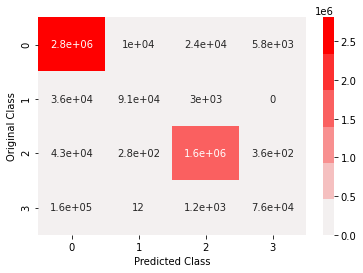

In [8]:
def plot_confusion_matrix(y_true,y_predict):
    X=confusion_matrix(y_true,y_predict)
    labels=[1,2,3,4]    
    sns.heatmap(X,annot=True,cmap=sns.light_palette("red"))
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
print('Confusion matrix')
plot_confusion_matrix(y_data,prediction)

**Final** **Prediction**

In [9]:
prediction_data=data[:1].values[0]
prediction_data

array([ 1.00000000e+00,  1.00000000e+00, -5.28545000e+00,  2.67758010e+01,
       -9.52731000e+00, -1.27932000e+01,  1.67178000e+01,  3.37374990e+01,
        2.37122990e+01, -6.69587000e+00,  2.92321000e+01,  2.48428990e+01,
        3.92134000e+00,  1.84470010e+01,  1.07547000e+00,  3.09029000e+00,
        3.73689990e+01,  1.74375990e+01,  1.92019000e+01,  2.05968000e+01,
       -3.95115000e+00,  1.45076000e+01, -4.52000000e+03,  8.17705994e+02,
        3.88829987e+02])

In [10]:
def final_2(x):
    start = timeit.timeit()
    final_data=np.zeros(12)
    final_data[0]=x[0]       #crew
    final_data[1]=x[1]       #seat
    gsr =pickle.load(open("gsrscalar.sav","rb"))
    r =pickle.load(open("filtered_rscalar.sav","rb"))
    ecg =pickle.load(open("filtered_ecgscalar.sav","rb"))
    eeg_encoder_1 =pickle.load(open("eeg_encoder_1scalar.sav","rb"))
    eeg_encoder_2 =pickle.load(open("eeg_encoder_2scalar.sav","rb"))
    eeg_encoder_3 =pickle.load(open("eeg_encoder_3scalar.sav","rb"))
    eeg_encoder_4 =pickle.load(open("eeg_encoder_4scalar.sav","rb"))
    eeg_encoder_5 =pickle.load(open("eeg_encoder_5scalar.sav","rb"))
    component_1 =pickle.load(open("component_1scalar.sav","rb"))
    component_2 =pickle.load(open("component_2scalar.sav","rb"))
    gsr=gsr.transform(x[-1].reshape(-1, 1))[0][0] 
    r=r.transform(x[-2].reshape(-1, 1))[0][0]
    ecg=ecg.transform(x[-3].reshape(-1, 1))[0][0]
    final_data[2]=gsr     #gsr
    final_data[3]=r      #r
    final_data[4]=ecg      #ecg
    eeg=x[2:-3].reshape(1,-1)
    feature_encoder=tf.keras.models.load_model('encoder.h5')
    hidden_feature=feature_encoder.predict(eeg)[0]
    eeg_encoder_1=eeg_encoder_1.transform(hidden_feature[0].reshape(-1, 1))[0][0] 
    eeg_encoder_2=eeg_encoder_2.transform(hidden_feature[1].reshape(-1, 1))[0][0] 
    eeg_encoder_3=eeg_encoder_3.transform(hidden_feature[2].reshape(-1, 1))[0][0] 
    eeg_encoder_4=eeg_encoder_4.transform(hidden_feature[3].reshape(-1, 1))[0][0] 
    eeg_encoder_5=eeg_encoder_5.transform(hidden_feature[4].reshape(-1, 1))[0][0] 
    final_data[5]=eeg_encoder_1
    final_data[6]=eeg_encoder_2
    final_data[7]=eeg_encoder_3
    final_data[8]=eeg_encoder_4
    final_data[9]=eeg_encoder_5
    pca_model=pickle.load(open("pca.sav","rb"))
    component=pca_model.transform(eeg)
    component_1=component_1.transform(component[0][0].reshape(-1, 1))[0][0]
    component_2=component_2.transform(component[0][1].reshape(-1, 1))[0][0]
    final_data[10]=component_1
    final_data[11]=component_2
    model=pickle.load(open("lgbt_model.sav","rb"))
    prediction=model.predict(final_data.reshape(1,-1))
    predict_proba=model.predict_proba(final_data.reshape(1,-1))
    end = timeit.timeit()
    time=end-start
    return prediction,predict_proba,time
prediction,predict_proba,time=final_2(prediction_data)
print("Time Taken",time)
print('Predicted state :',prediction[0])
print('probality of states state :',predict_proba[0])

Time Taken 0.0018397829999230453
Predicted state : 0
probality of states state : [8.89500593e-01 1.00921166e-01 9.57393825e-03 4.30185346e-06]


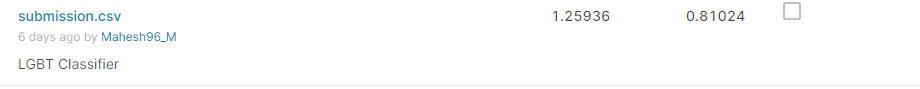

Heroku deployment link :
https://ancient-eyrie-46230.herokuapp.com/